In [1]:
import pandas as pd
import numpy as np
import os
import sys
import configparser
import collections
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score

sys.path.append(os.path.abspath('../../Module'))
import preprocessing
import evaluation
import visualize

config = configparser.ConfigParser()
config.read('../../config.ini')

vg_json = config['PATHS']['vg-json']
vg_json_export = config['PATHS']['json-export']
image_dir = config['PATHS']['vg-images']

colors = preprocessing.basic_colors()
num_classes = 11

# Daten importieren

In [2]:
# Gezippte Numpy-Archive importieren
perceptron_arrays = np.load(vg_json_export+'baseline_arrays_bgr.npz')

train_x = perceptron_arrays['train_x']
train_y = perceptron_arrays['train_y']
test_x = perceptron_arrays['test_x']
test_y = perceptron_arrays['test_y']
dev_x = perceptron_arrays['dev_x']
dev_y = perceptron_arrays['dev_y']

In [3]:
rus = RandomUnderSampler(random_state=123)
test_x_res, test_y_res = rus.fit_resample(test_x[:,1:], test_y[:,1:].argmax(axis=1))
test_y_res = np.eye(11)[test_y_res]
dev_x_res, dev_y_res = rus.fit_resample(dev_x[:,1:], dev_y[:,1:].argmax(axis=1))
dev_y_res = np.eye(11)[dev_y_res]

In [4]:
def sampling_steps(count_list, array_x, array_y):
    """
    Gehe Werte in count_list durch
    gib für jeden Schritt ein Sample vom DataFrame aus, das für jede Farbkategorie 
    die Anzahl von Instanzen enthält, die dem aktuellen Wert in count_list entspricht
    Wenn weniger Instanzen für eine Klasse: Oversampling durch RandomOverSampler
    """
    # Erfassen: Wieviele Instanzen / Farbe in gegebenen Arrays? DataFrame aus Arrays erzeugen
    color_values = array_y[:,1:].argmax(axis=1)
    color_values.shape = (len(color_values),1)
    df = pd.DataFrame(np.append(array_y, color_values, axis=1))
    color_counts_dict = dict(df.groupby([12]).size().reset_index(name='count').values)
    
    res_list = []
    # RandomOverSampler
    ros = RandomOverSampler(random_state=123)
    
    # Über gegebene Werte iterieren
    for val in count_list:
        sample_df = pd.DataFrame(columns=df.columns)
        
        # Über Farbwerte iterieren
        for i in list(range(0,11)):
            # Maximalwert für jeweilige Farbe überprüfen
            color_count = len(df.loc[df[12] == i])
            # Anzahl der Samples: Gegebener Wert wenn kleiner/gleich Anzahl Farbinstanzen, sonst Anzahl Farbinstanzen; Samples zu sample_df
            n = (val if color_count >= val else color_count)
            sample_df = sample_df.append(df.loc[df[12] == i].sample(n, replace=False, random_state=123))
        
        # OverSampling, wenn Anzahl Instanzen für ein Farbwort niedriger als gegebener Wert
        ids = sample_df.to_numpy()[:,0].reshape(-1, 1)
        ids_y = sample_df.to_numpy()[:,12].reshape(-1, 1)
        ids_r, _ = ros.fit_resample(ids, ids_y)
    
        # Einträge aus Input_Arrays auswählen, deren ID in sample_df ist
        out_x = pd.merge(pd.DataFrame(array_x),pd.DataFrame(ids_r), on=0).to_numpy()
        out_y = pd.merge(pd.DataFrame(array_y),pd.DataFrame(ids_r), on=0).to_numpy()
        # Ausgewählte Einträge als Set (x-array, y-array) zur Results-Liste hinzufügen
        res_list.append((out_x, out_y))
    return res_list

# Modell compilen, Funktionen definieren

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
import numpy as np

batch_size = 128
epochs = 25

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(512,)))
model.add(Dropout(0.2))
model.add(Dense(240, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

# model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
def model_prediction(model, tr_x, tr_y, te_x, te_y):
    tr_x = (tr_x[:,1:] if tr_x.shape[1] == 513 else tr_x)
    te_x = (te_x[:,1:] if te_x.shape[1] == 513 else te_x)
    tr_y = (tr_y[:,1:] if tr_y.shape[1] == 12 else tr_y)
    te_y = (te_y[:,1:] if te_y.shape[1] == 12 else te_y)

    #print(tr_x.shape[0], 'train samples')
    #print(te_x.shape[0], 'test samples')

    history = model.fit(tr_x, tr_y,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_data=(te_x, te_y))

    _predict_y = model.predict(te_x)
    
    return (_predict_y)

In [7]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, label_ranking_average_precision_score


steps = [5000,10000,20000,30000,40000,50000,60000]
predictions = []
input_arrays = []

accuracy_list = []
precision_list = []
recall_list = []
fscore_list = []

for i in sampling_steps(steps,train_x, train_y):
    input_arrays.append(i)
    x_res, y_res = i
    prediction = model_prediction(model, x_res, y_res, dev_x_res, dev_y_res)
    predictions.append(prediction)
    accuracy = accuracy_score(dev_y_res.argmax(axis=1), prediction.argmax(axis=1))
    precision,recall,fscore,support = precision_recall_fscore_support(dev_y_res.argmax(axis=1),prediction.argmax(axis=1),
                                                                  average='macro', warn_for=('precision', 'recall', 'f-score'))
    
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    fscore_list.append(fscore)

/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/sklearn/utils/validation.py:761: DataC

Instructions for updating:
Use tf.cast instead.


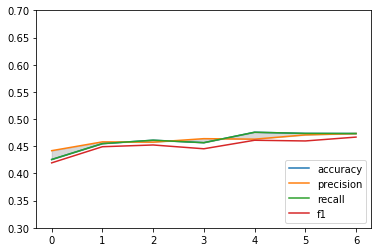

In [8]:
import seaborn

line1 = plt.plot(accuracy_list)
line2 = plt.plot(precision_list)
line3 = plt.plot(recall_list)
line4 = plt.plot(fscore_list)

axes = plt.gca()
axes.set_ylim([0.3,0.7])

plt.fill_between(np.arange(0,len(precision_list)),precision_list,recall_list,color='grey',alpha=0.3)

plt.legend(['accuracy','precision','recall','f1'], loc=4)

plt.show()

{'gray': 5000, 'pink': 5000, 'green': 5000, 'blue': 5000, 'yellow': 5000, 'brown': 5000, 'white': 5000, 'orange': 5000, 'red': 5000, 'black': 5000, 'purple': 5000}
Accuracy: 0.42561765411369634
              precision    recall  f1-score   support

       black       0.26      0.51      0.34      1895
        blue       0.47      0.50      0.49      1895
       brown       0.36      0.36      0.36      1895
        gray       0.33      0.26      0.29      1895
       green       0.52      0.53      0.52      1895
      orange       0.60      0.32      0.42      1895
        pink       0.44      0.64      0.52      1895
      purple       0.62      0.53      0.57      1895
         red       0.46      0.39      0.42      1895
       white       0.31      0.12      0.17      1895
      yellow       0.50      0.52      0.51      1895

   micro avg       0.43      0.43      0.43     20845
   macro avg       0.44      0.43      0.42     20845
weighted avg       0.44      0.43      0.42     

/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


{'gray': 10000, 'pink': 10000, 'green': 10000, 'blue': 10000, 'yellow': 10000, 'brown': 10000, 'white': 10000, 'orange': 10000, 'red': 10000, 'black': 10000, 'purple': 10000}
Accuracy: 0.4548332933557208
              precision    recall  f1-score   support

       black       0.41      0.30      0.35      1895
        blue       0.50      0.48      0.49      1895
       brown       0.34      0.47      0.39      1895
        gray       0.37      0.23      0.29      1895
       green       0.50      0.62      0.55      1895
      orange       0.58      0.45      0.51      1895
        pink       0.45      0.65      0.53      1895
      purple       0.66      0.52      0.58      1895
         red       0.46      0.49      0.48      1895
       white       0.27      0.23      0.25      1895
      yellow       0.50      0.56      0.53      1895

   micro avg       0.45      0.45      0.45     20845
   macro avg       0.46      0.45      0.45     20845
weighted avg       0.46      0.45     

/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


{'gray': 20000, 'pink': 20000, 'green': 20000, 'blue': 20000, 'yellow': 20000, 'brown': 20000, 'white': 20000, 'orange': 20000, 'red': 20000, 'black': 20000, 'purple': 20000}
Accuracy: 0.4611177740465339
              precision    recall  f1-score   support

       black       0.43      0.27      0.33      1895
        blue       0.46      0.59      0.52      1895
       brown       0.39      0.33      0.36      1895
        gray       0.35      0.28      0.31      1895
       green       0.51      0.60      0.55      1895
      orange       0.51      0.55      0.53      1895
        pink       0.53      0.60      0.57      1895
      purple       0.65      0.58      0.61      1895
         red       0.35      0.56      0.43      1895
       white       0.30      0.19      0.23      1895
      yellow       0.56      0.51      0.53      1895

   micro avg       0.46      0.46      0.46     20845
   macro avg       0.46      0.46      0.45     20845
weighted avg       0.46      0.46     

/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


{'gray': 30000, 'pink': 30000, 'green': 30000, 'blue': 30000, 'yellow': 30000, 'brown': 30000, 'white': 30000, 'orange': 30000, 'red': 30000, 'black': 30000, 'purple': 30000}
Accuracy: 0.4566082993523627
              precision    recall  f1-score   support

       black       0.41      0.31      0.35      1895
        blue       0.48      0.54      0.50      1895
       brown       0.38      0.35      0.37      1895
        gray       0.41      0.22      0.28      1895
       green       0.33      0.74      0.45      1895
      orange       0.56      0.48      0.52      1895
        pink       0.60      0.55      0.57      1895
      purple       0.60      0.62      0.61      1895
         red       0.47      0.55      0.50      1895
       white       0.34      0.15      0.20      1895
      yellow       0.54      0.51      0.52      1895

   micro avg       0.46      0.46      0.46     20845
   macro avg       0.46      0.46      0.45     20845
weighted avg       0.46      0.46     

/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


{'gray': 40000, 'pink': 40000, 'green': 40000, 'blue': 40000, 'yellow': 40000, 'brown': 40000, 'white': 40000, 'orange': 40000, 'red': 40000, 'black': 40000, 'purple': 40000}
Accuracy: 0.47579755337011276
              precision    recall  f1-score   support

       black       0.41      0.35      0.38      1895
        blue       0.46      0.59      0.52      1895
       brown       0.39      0.37      0.38      1895
        gray       0.38      0.25      0.30      1895
       green       0.46      0.65      0.54      1895
      orange       0.53      0.57      0.55      1895
        pink       0.58      0.55      0.56      1895
      purple       0.54      0.70      0.61      1895
         red       0.52      0.44      0.48      1895
       white       0.32      0.15      0.20      1895
      yellow       0.50      0.61      0.55      1895

   micro avg       0.48      0.48      0.48     20845
   macro avg       0.46      0.48      0.46     20845
weighted avg       0.46      0.48    

/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


{'gray': 50000, 'pink': 50000, 'green': 50000, 'blue': 50000, 'yellow': 50000, 'brown': 50000, 'white': 50000, 'orange': 50000, 'red': 50000, 'black': 50000, 'purple': 50000}
Accuracy: 0.47363876229311586
              precision    recall  f1-score   support

       black       0.43      0.31      0.36      1895
        blue       0.40      0.67      0.50      1895
       brown       0.38      0.40      0.39      1895
        gray       0.41      0.20      0.27      1895
       green       0.46      0.66      0.54      1895
      orange       0.50      0.58      0.54      1895
        pink       0.65      0.50      0.56      1895
      purple       0.62      0.65      0.63      1895
         red       0.50      0.47      0.49      1895
       white       0.32      0.17      0.22      1895
      yellow       0.52      0.59      0.55      1895

   micro avg       0.47      0.47      0.47     20845
   macro avg       0.47      0.47      0.46     20845
weighted avg       0.47      0.47    

/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


{'gray': 60000, 'pink': 60000, 'green': 60000, 'blue': 60000, 'yellow': 60000, 'brown': 60000, 'white': 60000, 'orange': 60000, 'red': 60000, 'black': 60000, 'purple': 60000}
Accuracy: 0.47344686975293837
              precision    recall  f1-score   support

       black       0.46      0.23      0.31      1895
        blue       0.47      0.58      0.52      1895
       brown       0.37      0.38      0.37      1895
        gray       0.36      0.32      0.34      1895
       green       0.49      0.65      0.56      1895
      orange       0.50      0.59      0.54      1895
        pink       0.51      0.59      0.54      1895
      purple       0.66      0.62      0.64      1895
         red       0.49      0.50      0.49      1895
       white       0.30      0.28      0.29      1895
      yellow       0.60      0.48      0.54      1895

   micro avg       0.47      0.47      0.47     20845
   macro avg       0.47      0.47      0.47     20845
weighted avg       0.47      0.47    

/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


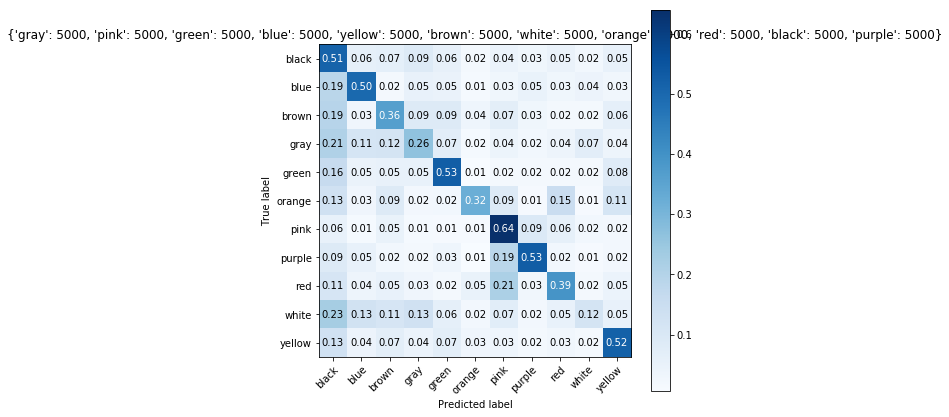

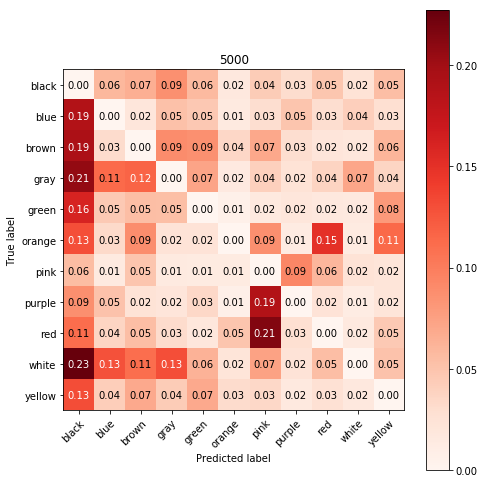

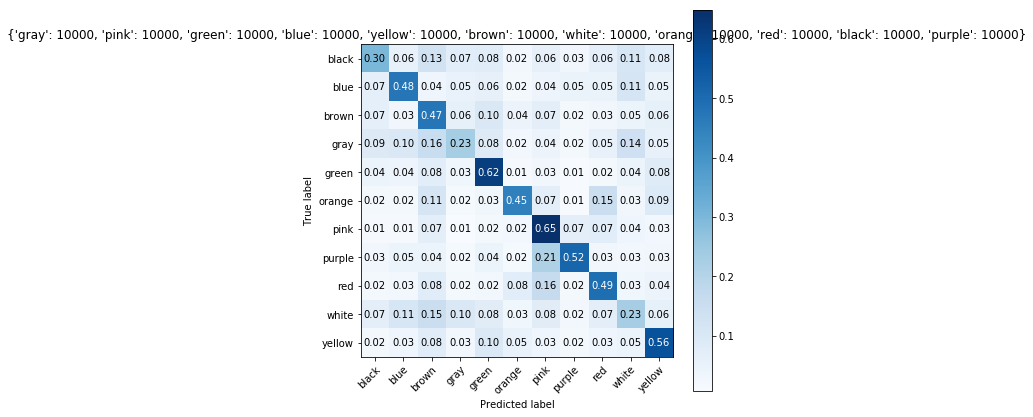

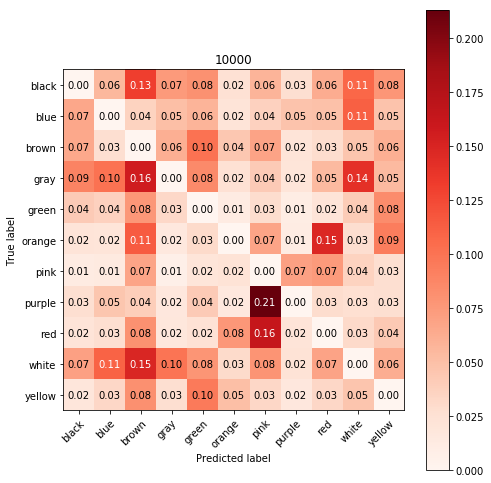

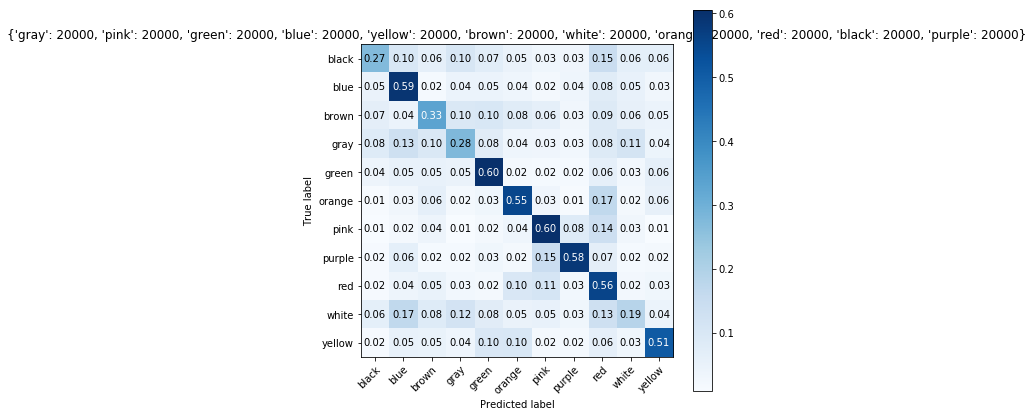

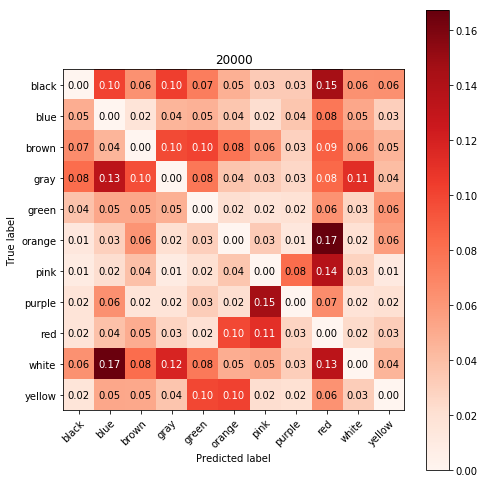

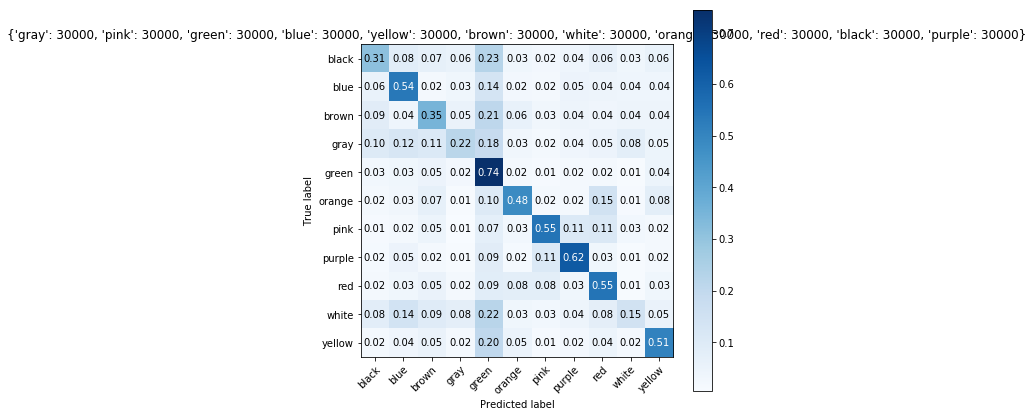

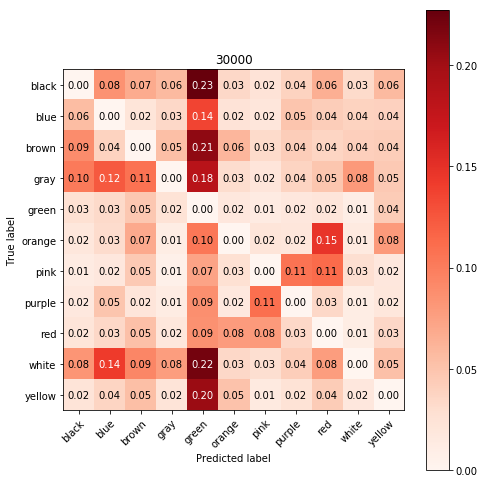

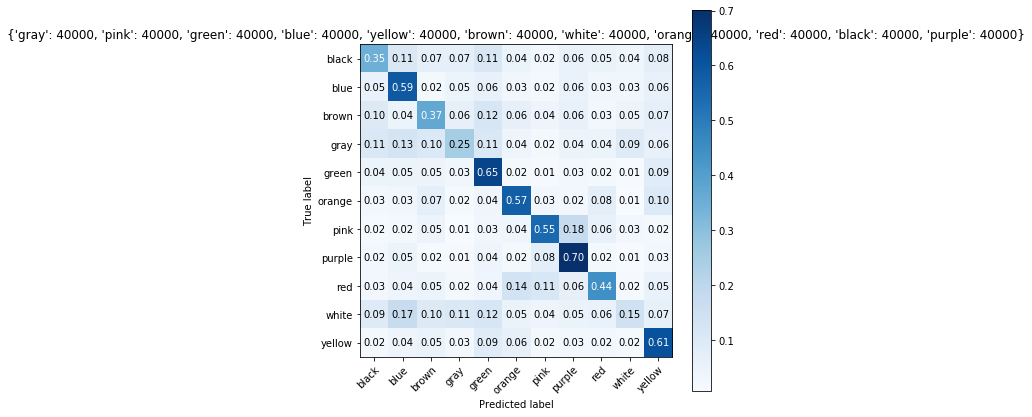

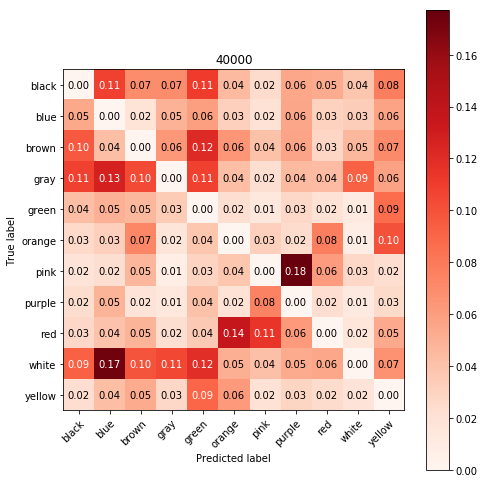

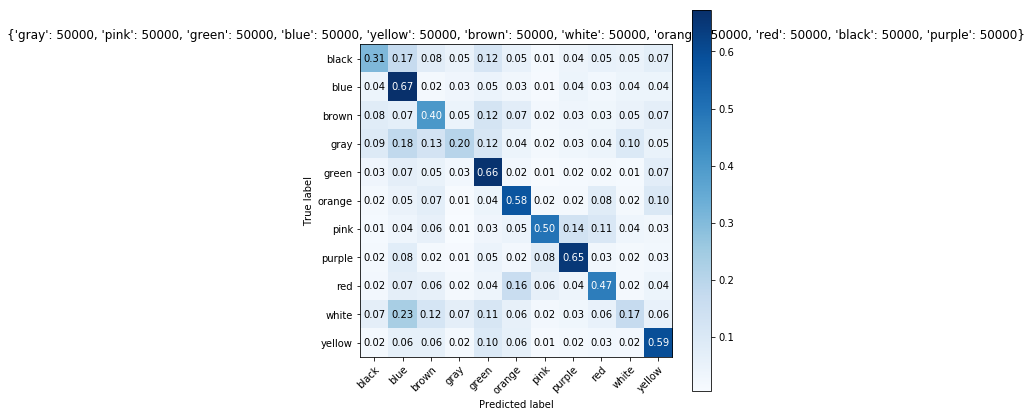

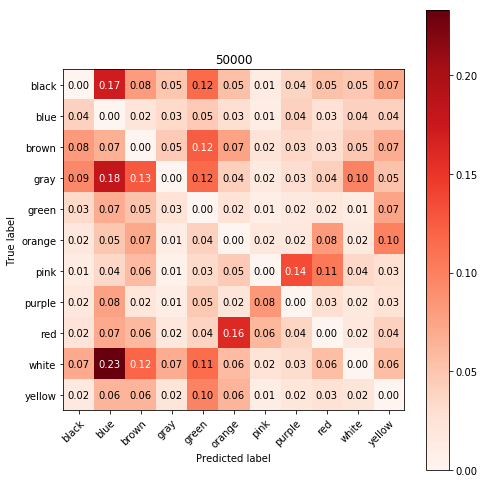

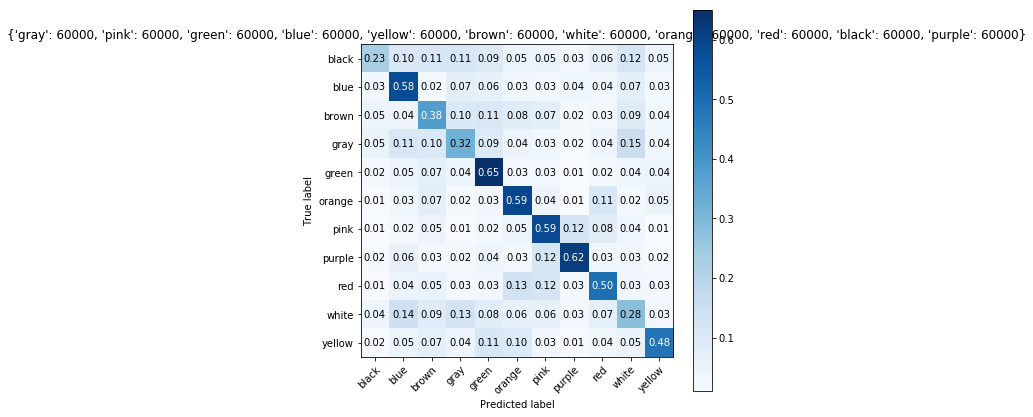

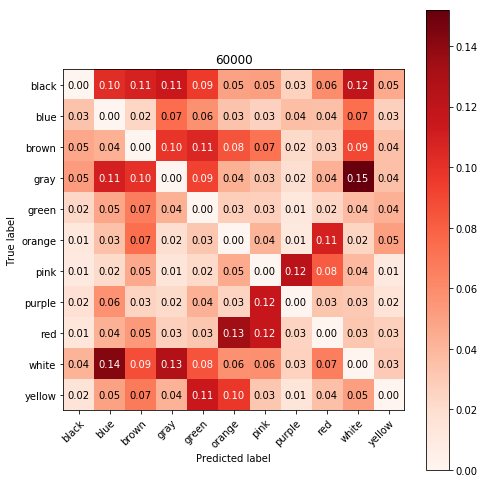

In [9]:
n = 0
for p in predictions:
    number_items = list(collections.Counter(input_arrays[n][1][:,1:].argmax(axis=1)).values())
    items = dict(zip(colors, number_items))
    print (items)
    print ('Accuracy:', accuracy_score(dev_y_res.argmax(axis=1),p.argmax(axis=1), normalize=True, sample_weight=None))
    print (classification_report(dev_y_res.argmax(axis=1),p.argmax(axis=1), 
                             labels=None, target_names=colors, sample_weight=None, digits=2, output_dict=False))
    print ('Mean Reciprocal Rank:',label_ranking_average_precision_score(dev_y_res,p),'\n')
    evaluation.plot_confusion_matrix(dev_y_res.argmax(axis=1),p.argmax(axis=1), colors, title=items)
    evaluation.plot_confusion_matrix(dev_y_res.argmax(axis=1),p.argmax(axis=1), colors, error_matrix=True, cmap=plt.cm.Reds, title=steps[n])
    n += 1